In [45]:
# to display images inline
%matplotlib inline

import cv2
import sys
import matplotlib.cbook as cbook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from PIL import Image
import ast
from tqdm.notebook import tqdm
import csv
import random
import hashlib
import numpy as np
import os
from operator import itemgetter 
from os import listdir
from os.path import isfile, join
import pandas as pd
import json
from os import listdir
from os.path import isfile, join

sys.path.append('../../')
from image_size import get_image_size # source: https://github.com/scardine/image_size

In [46]:
DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [47]:
#scraped_images = [img for img in listdir(DIR_PATH+'scraped_photos_final') if img != '.DS_Store']
scraped_images = [img for img in listdir(DIR_PATH+'newspaper-navigator-master/beyond_words_data/images') if img != '.DS_Store']

In [48]:
with open(DIR_PATH + "Master_degree/additional_data/train_80_percent.json") as jsonFile:
    coco_metadata_train = json.load(jsonFile)
    jsonFile.close()
    
with open(DIR_PATH + "Master_degree/additional_data/val_20_percent.json") as jsonFile:
    coco_metadata_test = json.load(jsonFile)
    jsonFile.close()

In [49]:
# train
len(coco_metadata_train['images']), len(coco_metadata_train['annotations'])

(2846, 38478)

In [50]:
# test
len(coco_metadata_test['images']), len(coco_metadata_test['annotations'])

(712, 9931)

In [51]:
# combined 
len(scraped_images), len(coco_metadata_train['images'])+len(coco_metadata_test['images']), len(coco_metadata_train['annotations'])+len(coco_metadata_test['annotations'])

(3559, 3558, 48409)

In [52]:
# one image is missing in source train-test (provided by newspaper-navigator), so I have to find it
train_img_names = []
for i in range(len(coco_metadata_train['images'])):
    train_img_names.append(coco_metadata_train['images'][i]['file_name'])
    
test_img_names = []
for i in range(len(coco_metadata_test['images'])):
    test_img_names.append(coco_metadata_test['images'][i]['file_name'])

In [53]:
[x for x in scraped_images if x not in (train_img_names + test_img_names)]

['728.jpg']

In [54]:
# okey, I found it, now let's remove it from our list
scraped_images.remove('728.jpg')

In [55]:
# now lenghts are equal
len(scraped_images), (len(coco_metadata_train['images'])+len(coco_metadata_test['images']))

(3558, 3558)

In [56]:
# coco format structure overview
list(coco_metadata_train.keys())

['info', 'licenses', 'categories', 'images', 'annotations']

In [57]:
coco_metadata_train['info']

{'description': 'Beyond Words Dataset (verified)',
 'URL': 'http://beyondwords.labs.loc.gov/#/',
 'version': '1.0',
 'year': 2020,
 'contributor': 'LC Labs',
 'date_created': '03/17/2020'}

In [58]:
coco_metadata_train['licenses'][0]

{'url': 'https://creativecommons.org/publicdomain/zero/1.0/',
 'id': 1,
 'name': 'CC0 1.0'}

In [59]:
coco_metadata_train['categories']

[{'id': 0, 'name': 'Photograph', 'supercategory': 'Content'},
 {'id': 1, 'name': 'Illustration', 'supercategory': 'Content'},
 {'id': 2, 'name': 'Map', 'supercategory': 'Content'},
 {'id': 3, 'name': 'Comics/Cartoon', 'supercategory': 'Content'},
 {'id': 4, 'name': 'Editorial Cartoon', 'supercategory': 'Content'},
 {'id': 5, 'name': 'Headline', 'supercategory': 'Content'},
 {'id': 6, 'name': 'Advertisement', 'supercategory': 'Content'}]

In [67]:
coco_metadata_train['images'][0]

{'license': 1,
 'file_name': '1.jpg',
 'url': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/kyu_dubnium_ver01/data/sn86069496/00280763251/1918082801/0282.jpg',
 'height': 1330,
 'width': 912,
 'date_captured': '12/1/2019',
 'id': 1}

In [84]:
coco_metadata_train['annotations'][0]

{'id': 3988,
 'bw_id': '5d49ec38ebaf180001001c9d',
 'image_id': 1,
 'category_id': 0,
 'bbox': [612, 92, 271, 338],
 'iscrowd': 0,
 'area': 91598}

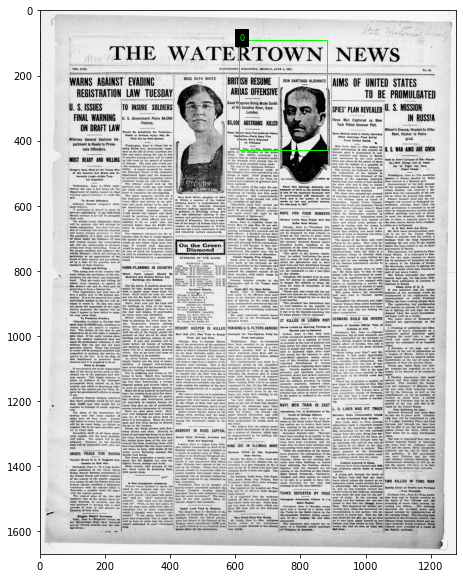

In [77]:
with cbook.get_sample_data(DIR_PATH+'newspaper-navigator-master/beyond_words_data/images/' + '1.jpg') as image_file:
    image = plt.imread(image_file)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(image, cmap='gray')

rect = matplotlib.patches.Rectangle(
    (612, 92), 
    271, 
    338, 
    linewidth=1, 
    edgecolor='lime', 
    facecolor='none'
)

ax.add_patch(rect)           
ax.text(
    612, 
    92, 
    0, 
    fontsize=8,
    backgroundcolor='black',
    color='lime'
)

plt.show()

In [23]:
def rescale_annotations(coco_metadata):
    for i in tqdm(range(len(coco_metadata['images']))):
        iterable_path_i = coco_metadata['images'][i]
        file_name = iterable_path_i['file_name']
        scraped_photo_width, scraped_photo_height = get_image_size.get_image_size(
            DIR_PATH+'scraped_photos_final/'+file_name
        )
        scaler_height = scraped_photo_height/iterable_path_i['height']
        scaler_width = scraped_photo_width/iterable_path_i['width']

        iterable_path_i['height'], iterable_path_i['width'] = scraped_photo_height, scraped_photo_width

        for ii in range(len(coco_metadata['annotations'])):
            if int(coco_metadata['annotations'][ii]['image_id']) == int(iterable_path_i['file_name'].split('.')[0]):
                iterable_path_ii = coco_metadata['annotations'][ii]
                # bbox in coco should be [x,y,width,height]
                iterable_path_ii['bbox'][0], iterable_path_ii['bbox'][2] = int(iterable_path_ii['bbox'][0]*scaler_width), int(iterable_path_ii['bbox'][2]*scaler_width)
                iterable_path_ii['bbox'][1], iterable_path_ii['bbox'][3] = int(iterable_path_ii['bbox'][1]*scaler_height), int(iterable_path_ii['bbox'][3]*scaler_height)
                
                iterable_path_ii['area'] = iterable_path_ii['bbox'][2]*iterable_path_ii['bbox'][3]
                
    return coco_metadata

In [24]:
# # I scraped better resolution data (than are provided in source repository of newspaper-navigator) 
# # so i need to change height and width and also annotation bbox'es
# coco_metadata_train = rescale_annotations(coco_metadata_train)
# coco_metadata_test = rescale_annotations(coco_metadata_test)

In [25]:
coco_metadata_train['images'][0]

{'license': 1,
 'file_name': '1.jpg',
 'url': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/kyu_dubnium_ver01/data/sn86069496/00280763251/1918082801/0282.jpg',
 'height': 1330,
 'width': 912,
 'date_captured': '12/1/2019',
 'id': 1}

In [26]:
coco_metadata_train['annotations'][0]

{'id': 3988,
 'bw_id': '5d49ec38ebaf180001001c9d',
 'image_id': 1,
 'category_id': 0,
 'bbox': [612, 92, 271, 338],
 'iscrowd': 0,
 'area': 91598}

In [27]:
def reduce_original_coco_json(coco_metadata):
    del coco_metadata['info']
    del coco_metadata['licenses']
    
    for i in range(len(coco_metadata['categories'])):
        del coco_metadata['categories'][i]['supercategory']
    
    for ii in range(len(coco_metadata['images'])):
        del coco_metadata['images'][ii]['license']
        del coco_metadata['images'][ii]['url']
        del coco_metadata['images'][ii]['date_captured']
    
    for iii in range(len(coco_metadata['annotations'])):
        del coco_metadata['annotations'][iii]['id']
        del coco_metadata['annotations'][iii]['bw_id']
        coco_metadata['annotations'][iii]['id'] = coco_metadata['annotations'][iii].pop('image_id')
        
    return coco_metadata

In [28]:
# I don't neet such amount of information stored in my jsons so I need to reduce them
coco_metadata_train = reduce_original_coco_json(coco_metadata_train)
coco_metadata_test = reduce_original_coco_json(coco_metadata_test)

In [29]:
def show_random_img_with_all_annotations(coco_metadata, path_to_photos, matplotlib_colours_list, pages=5):
    for i in range(pages):
        random_img = random.randint(0,len(coco_metadata['images']))
        file_name = coco_metadata['images'][random_img]['file_name']
        print(coco_metadata['images'][random_img]['file_name'])

        with cbook.get_sample_data(path_to_photos + file_name) as image_file:
            image = plt.imread(image_file)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(image, cmap='gray')

        for ii in range(len(coco_metadata['annotations'])):
            if int(coco_metadata['annotations'][ii]['id']) == int(coco_metadata['images'][i]['id']):
                category_id = coco_metadata['annotations'][ii]['category_id']
                string_category = coco_metadata_train['categories'][int(category_id)]['name']
                colour = matplotlib_colours_list[int(category_id)]
                x0 = coco_metadata['annotations'][ii]['bbox'][0]
                y0 = coco_metadata['annotations'][ii]['bbox'][1]
                width = coco_metadata['annotations'][ii]['bbox'][2]
                height = coco_metadata['annotations'][ii]['bbox'][3]
                rect = matplotlib.patches.Rectangle(
                    (x0, y0), 
                    width, 
                    height, 
                    linewidth=1, 
                    edgecolor=colour, 
                    facecolor='none'
                )
                ax.add_patch(rect)  
                
                ax.text(
                x0, 
                y0, 
                string_category, 
                fontsize=8,
                backgroundcolor='black',
                color=colour
            )

        plt.show()

2981.jpg


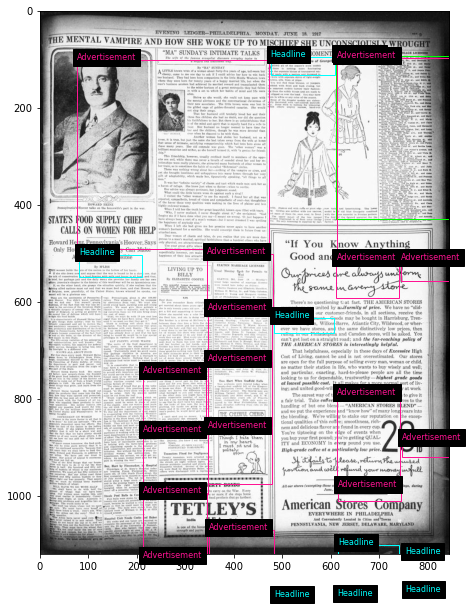

1117.jpg


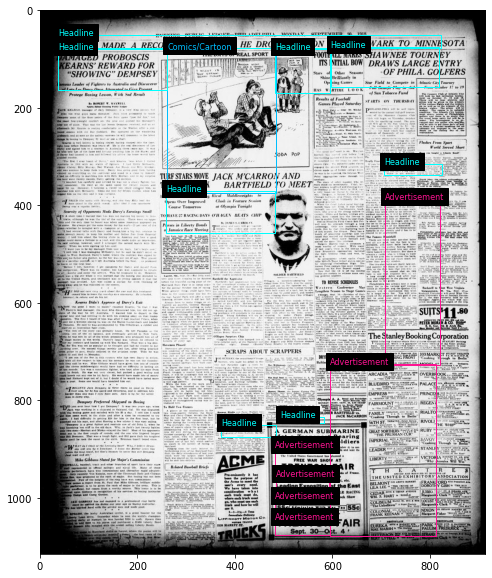

2581.jpg


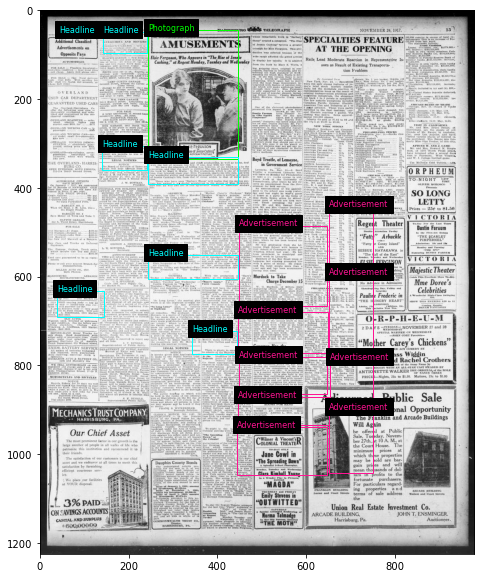

721.jpg


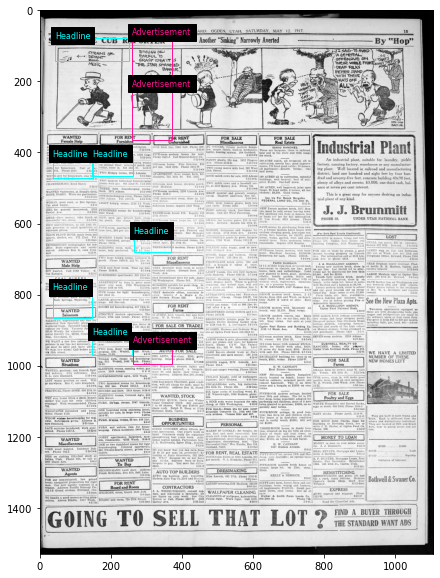

1436.jpg


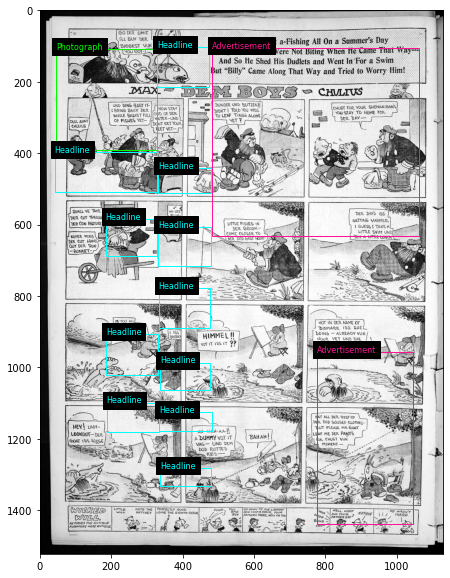

In [30]:
# some random images with annotations
show_random_img_with_all_annotations(
    coco_metadata_train,
    #DIR_PATH+'scraped_photos_final/',
    DIR_PATH+'newspaper-navigator-master/beyond_words_data/images/',
    ['lime','orangered','yellow','deepskyblue','violet','cyan','deeppink'],
)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



images/1978.jpg
images/2164.jpg
images/199.jpg
images/1324.jpg
images/2612.jpg
images/2485.jpg
images/2081.jpg
images/1542.jpg
images/2438.jpg
images/1836.jpg


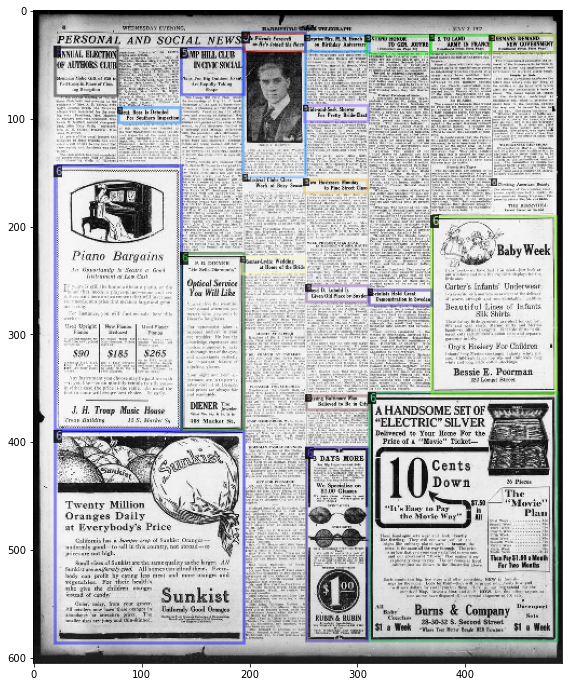

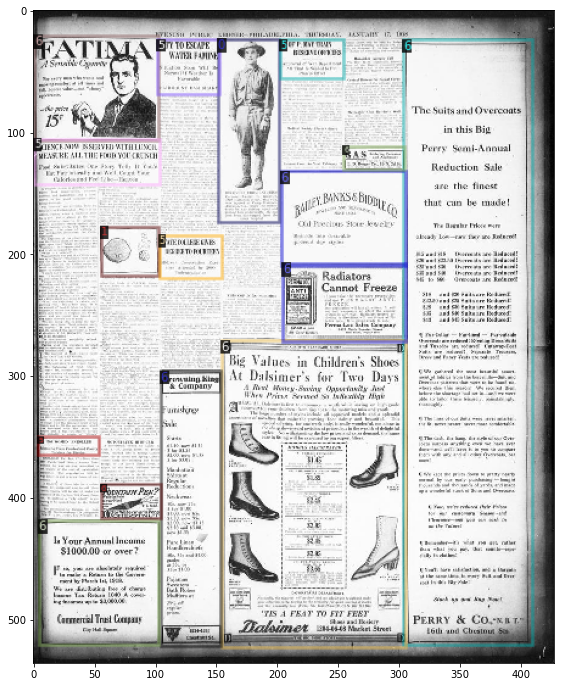

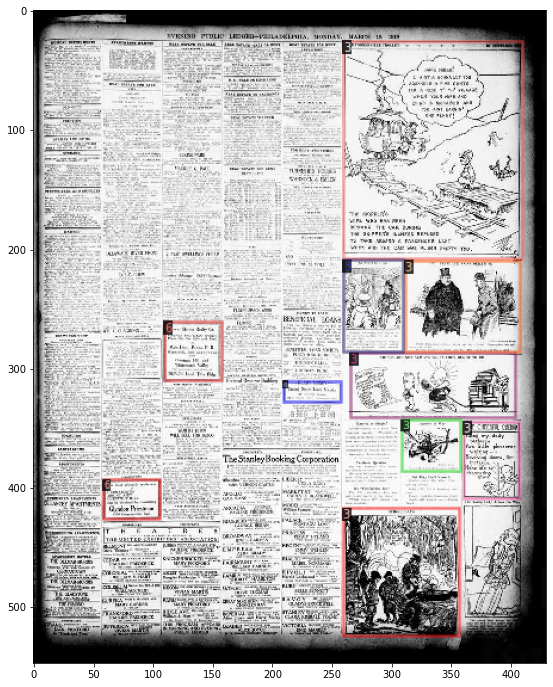

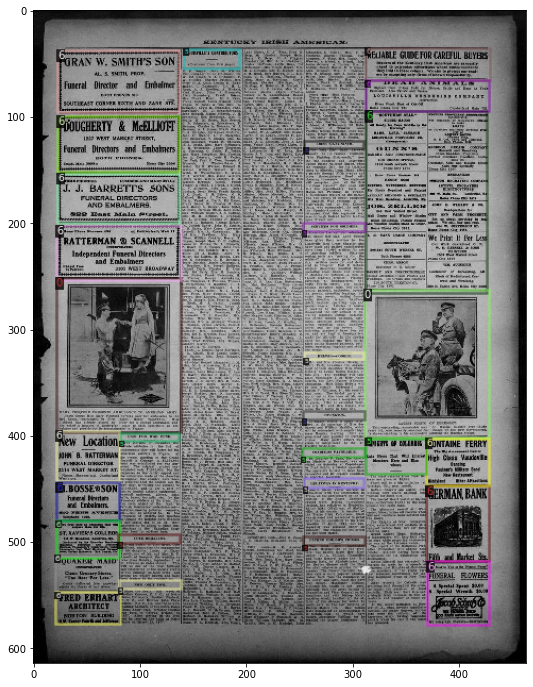

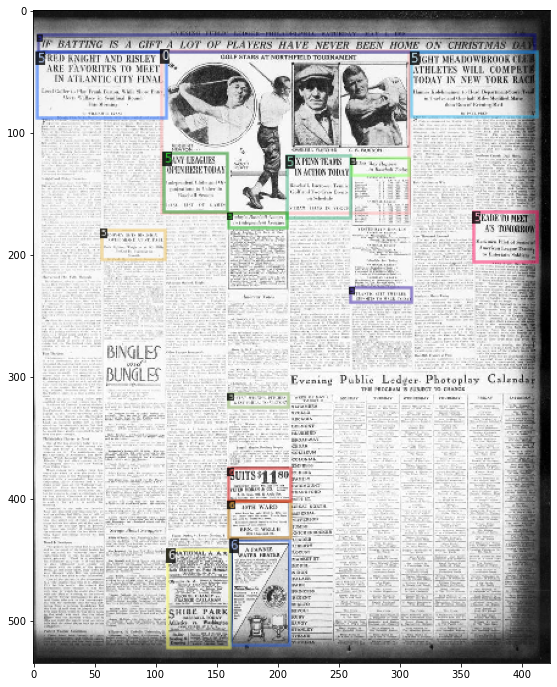

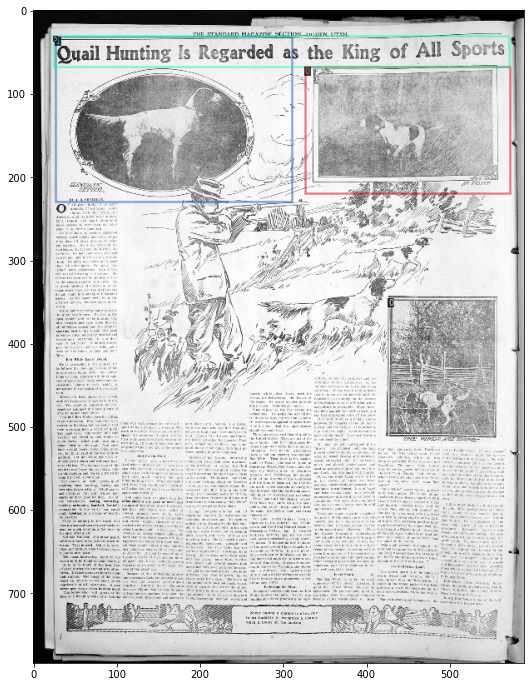

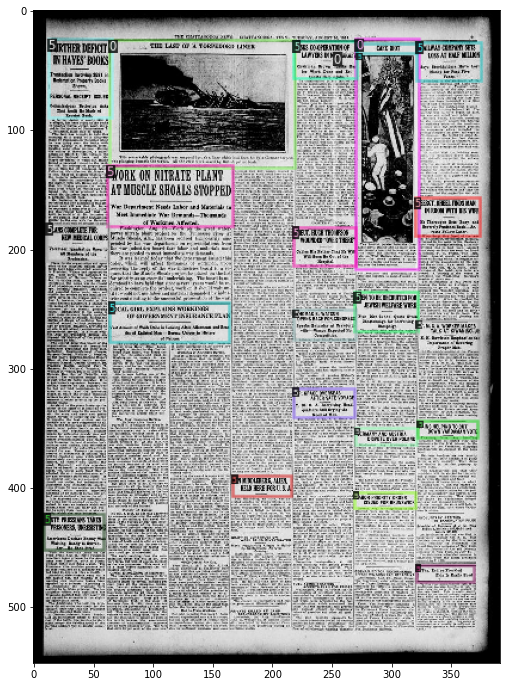

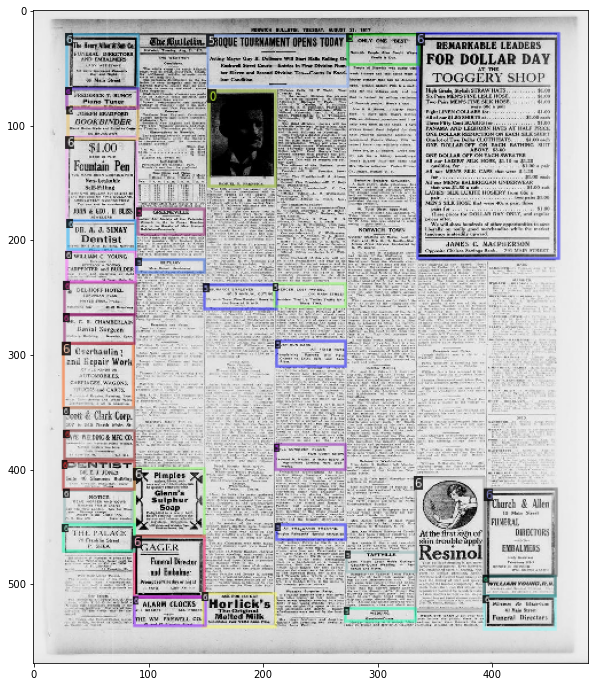

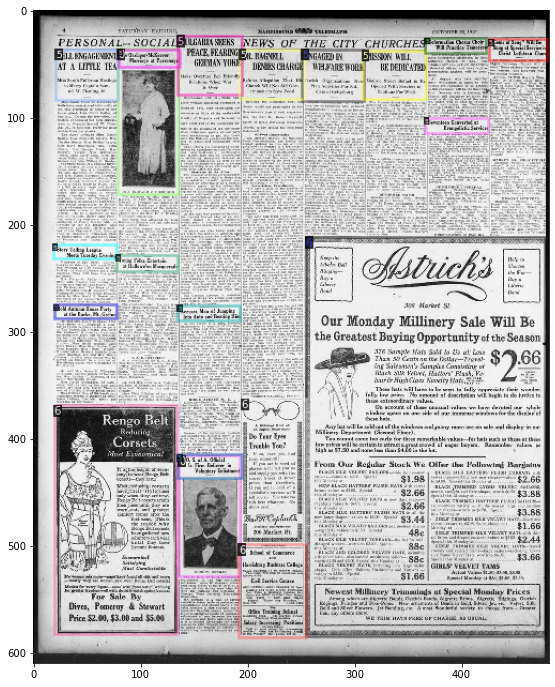

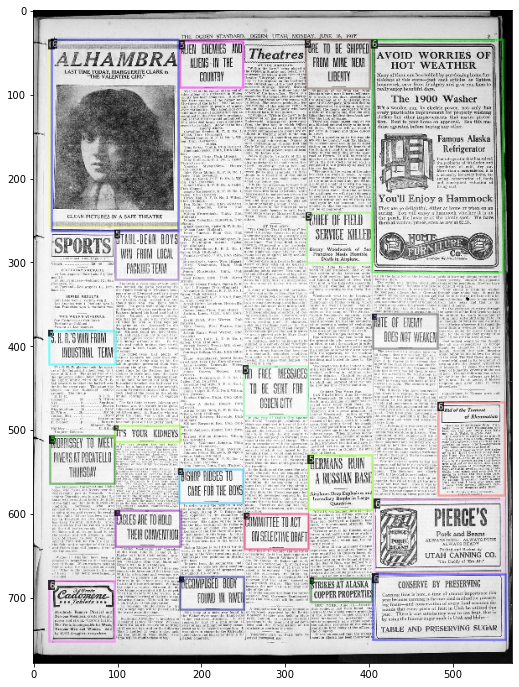

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

register_coco_instances(
    "beyond_words_train", 
    {}, 
    DIR_PATH + "Master_degree/additional_data/train_80_percent.json", 
    "images"
)
register_coco_instances(
    "beyond_words_val",
    {}, 
    DIR_PATH + "Master_degree/additional_data/val_20_percent.json", 
    "images"
)

# sets random seed for reproducibility
random.seed(0)

dataset_dicts = DatasetCatalog.get("beyond_words_train")
my_metadata = MetadataCatalog.get("beyond_words_val")

n_examples_to_display = 10
for d in random.sample(dataset_dicts, n_examples_to_display):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_metadata, scale=0.5)
    v = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(15,12))
    plt.imshow(v.get_image()[:, :, ::-1])

In [ ]:
# train test split
set_names = [
    scraped_images[i].split('.')[0] for i in range(len(scraped_images))
]

In [ ]:
def calcMD5Hash(name, split):
    return int(hashlib.md5(str(name).encode('Utf-8')).digest()[-1]) <= split * 256

In [ ]:
train_test_hash_list = list(pd.Series(set_names).apply(lambda x: calcMD5Hash(x, 0.8)))

In [ ]:
train_names1, test_names = [], []

for i in range(len(train_test_hash_list)):
    if train_test_hash_list[i] == True:
        train_names1.append(set_names[i])
    elif train_test_hash_list[i] == False:
        test_names.append(set_names[i])

In [ ]:
train_val_hash_list = list(pd.Series(train_names1).apply(lambda x: calcMD5Hash(x, 0.08)))

In [ ]:
train_names, val_names = [], []

for i in range(len(train_val_hash_list)):
    if train_val_hash_list[i] == True:
        val_names.append(train_names1[i])
    elif train_val_hash_list[i] == False:
        train_names.append(train_names1[i])

In [ ]:
len(train_names), len(test_names), len(val_names)

In [ ]:
# get another file metadata 
file = open(DIR_PATH + "Master_degree/additional_data/bw_website_data.json", "r")

bw_website_data = json.load(file)

In [ ]:
bw_website_data['data']

In [ ]:
meta_list = []
for i in tqdm(range(len(bw_website_data['data']))):
    for ii in range(len(annotations['annotations'])):
        if bw_website_data['data'][i]['id']==annotations['annotations'][ii]:
            meta_list.append(
                [
                    "_".join(bw_website_data['data'][i]['location']['standard'].split('.jpg')[0].split('/')[-4:]),
                    
                ]
            )
            break

In [ ]:
scraped_photo_keys = {}
for i in tqdm(range(len(bw_website_data['data']))):
    scraped_photo_keys[
        bw_website_data['data'][i]['id']
    ] = {'scraped_photo_name': "_".join(bw_website_data['data'][i]['location']['standard'].split('.jpg')[0].split('/')[-4:])}

In [ ]:
annotations['annotations'][0]['bw_id']

In [ ]:
for key in tqdm(scraped_photo_keys):
    for i in range(len(annotations['annotations'])):
        if annotations['annotations'][i]['bw_id'] == key:
            scraped_photo_keys[key]['bbox'] = annotations['annotations'][i]['bbox']

In [ ]:
list_of_image_annotaion_dicts = []
for i in tqdm(range(len(annotations['images']))):
    file_name = "_".join(annotations['images'][i]['url'].split('.jpg')[i].split('/')[-4:])
    width_from_annotations, height_from_annotations = annotations['images'][i]['width'], annotations['images'][i]['height']
        
    full_path_to_file = DIR_PATH + 'scraped_photos_more_data/' + file_name + '.jpg' 
    try:
        scraped_photo_width, scraped_photo_height = get_image_size.get_image_size(full_path_to_file)
    except:
        print(f'file_name={file_name} not found')
        
    scaler_width, scaler_height = scraped_photo_width/width_from_annotations, scraped_photo_height/height_from_annotations
    for ii in range(len(annotations['annotations'])):
        if annotations['annotations'][ii]['image_id'] == 
    
        annotations['annotations'][i]['bbox']

        particular_file_dict = {
                    'file_name': full_path_to_file,
                    'height': scraped_photo_height,
                    'width': scraped_photo_width,
                    'image_id': annotations['annotations'][i]['image_id'],
                    'annotations': {
                        'bbox': box,
                        'bbox_mode': 1,
                        'category_id': int(splitted_annotation[0])
                    }
                }

        list_of_image_annotaion_dicts.append(particular_file_dict)
    break